In [27]:
import pandas as pd
import tensorflow as tf
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import glob
#from glob import glob
from sklearn.utils import shuffle
from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall, AUC

In [28]:
#get the shape of one of the images
image_path = r"C:\Users\user\Anaconda\Programs\image_data\train\normal\KEMP_IMG_DATA_1.png"
img = Image.open(image_path)
img_width, img_height = img.size
img_channels = 3 if img.mode == 'RGB' else 1
print("Image Dimensions (Width, Height, Channels):", img_width, img_height, img_channels)

Image Dimensions (Width, Height, Channels): 480 720 1


Image Dataset Creation

In [29]:
class ImageClassification:
    def __init__(self,path1): #path1 represents the directory to the image dataset
        #creating dataframes (df) for the train and test sets
        self.train_df = self._create_df(path1, "train")
        self.test_df = self._create_df(path1, "test")

    #independent utilitity method
    @staticmethod
    #create dataframe with image path and the outcome (either normal or error)
    #construct the dataframes based on the paths to normal and error images found in the directory in path2
    def _create_df(path1, path2):
        #glob.glob is usedd to find all PNG files in the directories
        #files1 = glob.glob(os.path.join(path1+path2, "normal/*.png"))
        #files2 = glob.glob(os.path.join(path1+ path2, "error/*.png"))
        normal_path = os.path.join(path1, path2, "normal", "*png")
        error_path = os.path.join(path1, path2, "error", "*png")
        files1 = glob.glob(normal_path)
        files2 = glob.glob(error_path)
        print("Normal Path:", normal_path)
        print("Error Path:", error_path)
        #prints the number of normal and error images found
        print("normal: ", len(files1))
        print("error: ", len(files2))
            
        #constructs two data frames, df_n = error, df_p = normal
        df_n = pd.DataFrame()
        df_p = pd.DataFrame()
        df_n["name"] = [x for x in files2]
        df_n["outcome"] = 0.0
        df_p["name"] = [x for x in files1]
        df_p["outcome"] = 1.0
        #concatenates and shuffles the dataframes into a single dataframe 'df'
        df = pd.concat([df_n, df_p], axis=0, ignore_index=True)
        df = shuffle(df)
        return df

    #seperate X and Y to train your model
    #operates an instance of class self
    def create_x_and_y(self):
        #calls preprocessing method for each image path in train_df
        #creates an array 'X' of preprocessed images
        X = np.array([self.img_preprocess(p) for p in self.train_df.name.values])
        #retrieve the outcome column values from train_df
        Y = self.train_df.outcome.values

        print("Shape of X:", X.shape)
        return X, Y

    def test_x_and_y(self):
        #get the images in the test data
        X1 = np.array([self.img_preprocess(p) for p in self.test_df.name.values])
        #get the labels 0 and 1
        Y1 = self.test_df.outcome.values

        return X1, Y1

    @staticmethod
    def img_preprocess(image_path, target_size=(256, 256)):
        #load image
        img = Image.open(image_path)
        #convert to greyscale
        img = img.convert('L')
        #resize image
        img = img.resize(target_size)
        #convert to numpy array and reshape to 256, 256, 1
        img_array = np.array(img).reshape(target_size[0], target_size[1], 1)
        #convert to float32 and normalise value to be between 0 and 1
        img_array = img_array.astype('float32') / 255.0
        return img_array

#get current path of file
dir_path = os.path.join(os.getcwd(), "image_data")
#dir_path = r"C:\Users\user\Anaconda\Programs\Swinburne\archive\image_data"
print("Director Path :", dir_path)
aic = ImageClassification(path1=dir_path)

X, Y = aic.create_x_and_y()
X1, Y1 = aic.test_x_and_y()

Director Path : C:\Users\user\Anaconda\Programs\image_data
Normal Path: C:\Users\user\Anaconda\Programs\image_data\train\normal\*png
Error Path: C:\Users\user\Anaconda\Programs\image_data\train\error\*png
normal:  1102
error:  59
Normal Path: C:\Users\user\Anaconda\Programs\image_data\test\normal\*png
Error Path: C:\Users\user\Anaconda\Programs\image_data\test\error\*png
normal:  276
error:  15
Shape of X: (1161, 256, 256, 1)


Model Creation

In [30]:
#make variables
epochs = 20 #number of times training is done
input_shape = (256, 256, 1)
batch_size = 64

In [31]:
#fix the bias in the data 1st attempt
#add weights to the data, currently 95% is normal and 5% is error data
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute = compute_class_weight('balanced', classes=np.unique(Y), y=Y)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights :", class_weights_dict)

Class weights : {0: 9.838983050847459, 1: 0.5267695099818511}


In [33]:
pipe_model = Sequential()
#first create convulutional layer
pipe_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(256,256,1), padding='same'))
#than add another pooling layer
pipe_model.add(MaxPooling2D((2,2), padding='same'))
#add dropout, so not all neurons are on at the same time (prevent overfitting)
pipe_model.add(Dropout(0.25)) #25% of neurons dropped
#add 2nd convulutional layer
pipe_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
pipe_model.add(MaxPooling2D((2,2), padding='same'))
pipe_model.add(Dropout(0.3))
#flatten the vector before the fully connected layer
pipe_model.add(Flatten())
#dense layer (fcl)
pipe_model.add(Dense(1, activation='sigmoid'))

#compile the model, use binary cross entropy for the loss function and the adam optimizer
pipe_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy', Precision(), Recall(), AUC()])

In [34]:
pipe_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 64, 64, 64)       

In [36]:
X_train, Y_train = aic.create_x_and_y()

history = pipe_model.fit(X_train, Y_train,
                         epochs=20,  # Number of training epochs
                         batch_size=32,  # Number of samples per gradient update
                         validation_split=0.2,
                         class_weight=class_weights_dict)  # Fraction of training data to be used as validation data

Shape of X: (1161, 256, 256, 1)
Epoch 1/20
29/29 [==============================] - 24s 815ms/step - loss: 3.4506e-05 - accuracy: 1.0000 - precision_4: 1.0000 - recall_4: 1.0000 - auc_4: 1.0000 - val_loss: 6.7621e-05 - val_accuracy: 1.0000 - val_precision_4: 1.0000 - val_recall_4: 1.0000 - val_auc_4: 1.0000
Epoch 2/20
29/29 [==============================] - 22s 770ms/step - loss: 3.4900e-05 - accuracy: 1.0000 - precision_4: 1.0000 - recall_4: 1.0000 - auc_4: 1.0000 - val_loss: 7.2014e-05 - val_accuracy: 1.0000 - val_precision_4: 1.0000 - val_recall_4: 1.0000 - val_auc_4: 1.0000
Epoch 3/20
29/29 [==============================] - 22s 768ms/step - loss: 2.7057e-05 - accuracy: 1.0000 - precision_4: 1.0000 - recall_4: 1.0000 - auc_4: 1.0000 - val_loss: 6.8304e-05 - val_accuracy: 1.0000 - val_precision_4: 1.0000 - val_recall_4: 1.0000 - val_auc_4: 1.0000
Epoch 4/20
29/29 [==============================] - 23s 778ms/step - loss: 3.3013e-05 - accuracy: 1.0000 - precision_4: 1.0000 - recall_4

In [37]:
test_X, test_Y = aic.test_x_and_y()

test_eval = pipe_model.evaluate(test_X, test_Y, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])
print('Test precision:', test_eval[2])
print('Test recall:', test_eval[3])
print('Test AUC:', test_eval[4])

Test loss: 4.100281876162626e-05
Test accuracy: 1.0
Test precision: 1.0
Test recall: 1.0
Test AUC: 1.0


In [38]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'precision_4', 'recall_4', 'auc_4', 'val_loss', 'val_accuracy', 'val_precision_4', 'val_recall_4', 'val_auc_4'])


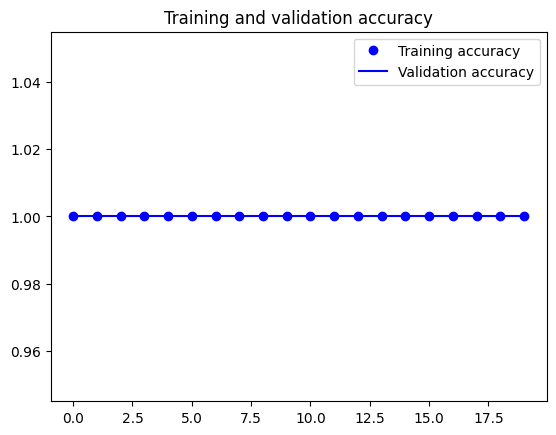

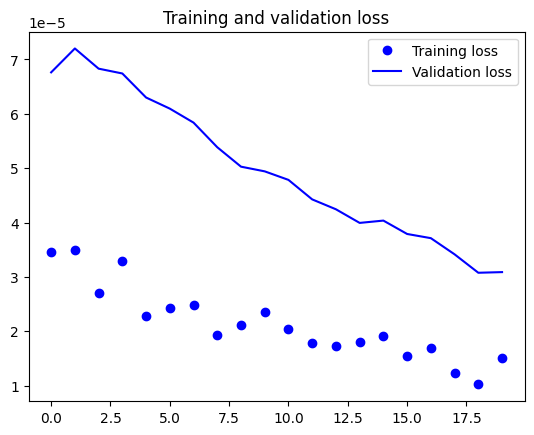

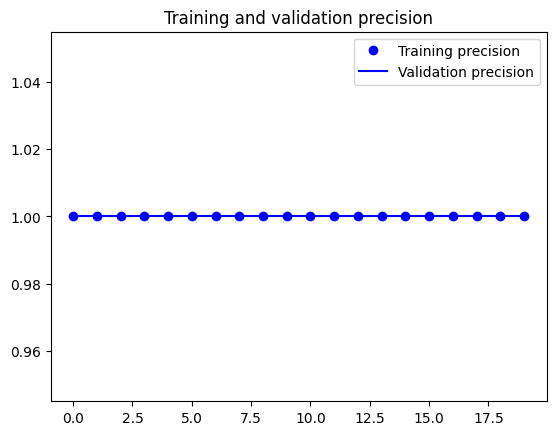

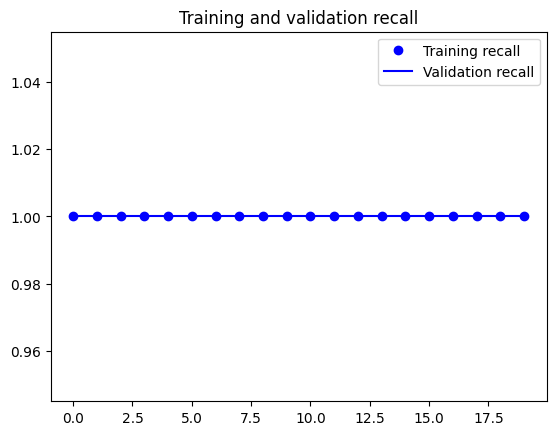

In [39]:
#Graph the accuracy and the loss
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
#Graph the accuracy and the loss
precision = history.history['precision_4']
val_precision = history.history['val_precision_4']
recall = history.history['recall_4']
val_recall = history.history['val_recall_4']
epochs = range(len(precision))
plt.plot(epochs, precision, 'bo', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure()
plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.show()

Plot the Reciever Operating Characteristic (ROC) and AUC

In [40]:
y_probs = pipe_model.predict(test_X)
#convert into integer value
y_preds = test_Y.astype(int)

10/10 [==============================] - 2s 155ms/step


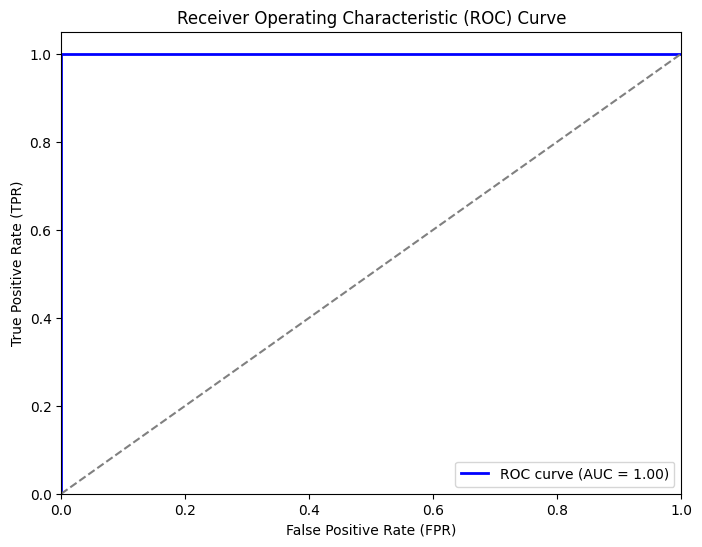

In [41]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(test_Y, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Confusion Matrix

In [42]:
#for confusion matrix
from matplotlib import colormaps
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

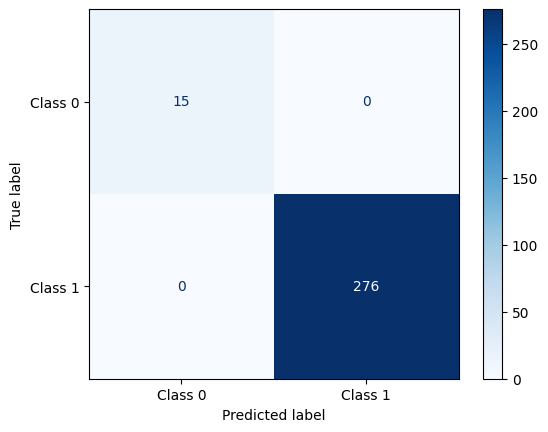

In [43]:
cm = confusion_matrix(test_Y, y_preds)

#plot it
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues, values_format='d');
plt.show()

Classification Report

In [25]:
from sklearn.metrics import classification_report
report = classification_report(test_Y, y_preds, target_names=['Class 0', 'Class 1'])
print(report)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        15
     Class 1       1.00      1.00      1.00       276

    accuracy                           1.00       291
   macro avg       1.00      1.00      1.00       291
weighted avg       1.00      1.00      1.00       291



In [97]:
prediction = pipe_model.predict(test_X)

10/10 [==============================] - 1s 120ms/step
